In [1]:
import os
import pathlib


import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.9.2
The following GPU devices are available: /device:GPU:0


2022-09-25 10:57:52.350229: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-25 10:57:52.897747: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:0 with 9205 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:41:00.0, compute capability: 7.5


# Import object detection tools

In [2]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

In [3]:
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline

# Model

#### Faster option:

A Single Shot MultiBox Detector (SSD) trained on COCO 2017 dataset, where Mobilenet v2 initialized from Imagenet classification checkpoint is used as a feature extractor. 

OR

#### More accurate option:

Faster R-CNN trained on COCO 2017 dataset (where images scaled to 640x640 resolution) with batch size 64, where Inception Resnet v2 (using regular Convolutions) initialized from Imagenet classification checkpoints is used as a feature extractor.

Load the model from tensorflow hub:


In [4]:
# model = hub.load('https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2')
model = hub.load('https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1')

2022-09-25 10:57:54.678221: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9205 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:41:00.0, compute capability: 7.5


The input tensor must be a tf.uint8 tensor with shape [1, height, width, 3] with values in [0, 255]

In [5]:
def image_into_numpy_array(path):
    #Puts image into numpy array to feed into tensorflow graph.
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))
    (width, height) = image.size
    return np.array(image.getdata()).reshape((1, height, width, 3)).astype(np.uint8)

### Read a test case image 
Images are taken by me :)

## Test case 1

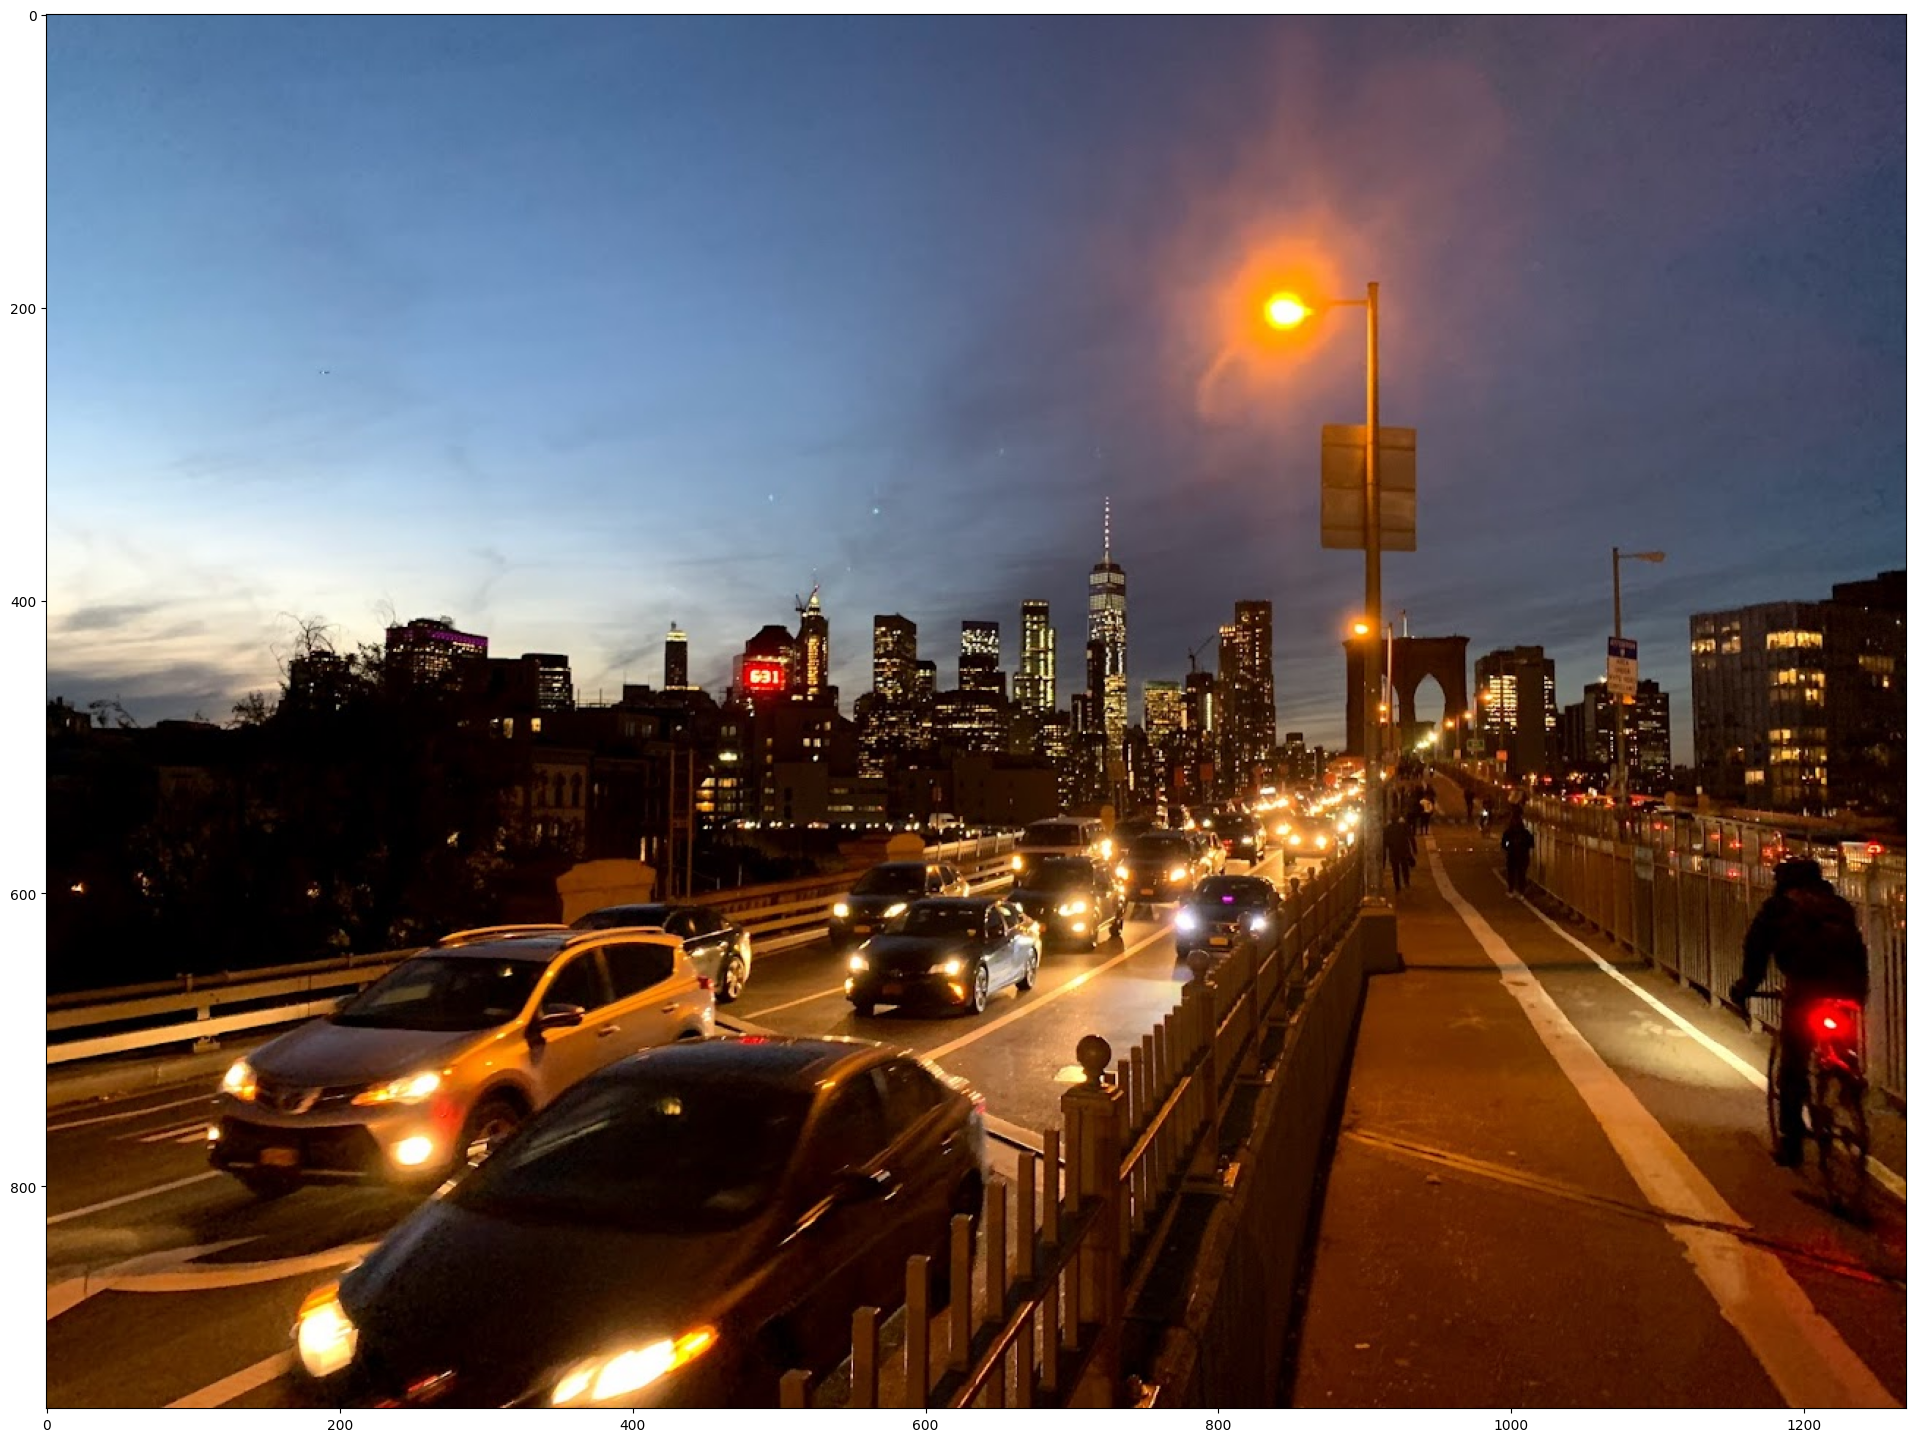

In [30]:
image_path = '/home/payam/bita/IMG_9563.jpg'
image_np = image_into_numpy_array(image_path)


plt.figure(figsize=(24,32))
plt.imshow(image_np[0])
plt.show()

In [31]:
image_np[0].shape

(952, 1270, 3)

In [32]:
# running inference
model_outputs = model(image_np)

# returns a dictionary
model_outputs.items()


dict_items([('detection_multiclass_scores', <tf.Tensor: shape=(1, 100, 91), dtype=float32, numpy=
array([[[5.4795104e-03, 9.9347913e-01, 7.5965055e-04, ...,
         2.5866396e-07, 3.0686873e-08, 1.1288252e-08],
        [1.9333168e-03, 2.2698489e-06, 2.6397572e-07, ...,
         1.5735727e-08, 5.2617008e-08, 4.1875111e-08],
        [7.5806971e-03, 1.8434870e-05, 5.7047248e-07, ...,
         6.2360996e-08, 5.3417669e-08, 3.4387163e-08],
        ...,
        [9.8467410e-01, 2.1874311e-03, 1.3876709e-05, ...,
         5.2321280e-07, 5.0385285e-08, 3.6617809e-08],
        [9.8650485e-01, 3.2556194e-04, 1.6409600e-05, ...,
         1.8686554e-06, 2.1924709e-08, 5.3150401e-08],
        [6.6826688e-03, 1.0082174e-05, 1.0376143e-06, ...,
         6.7346534e-08, 1.6531222e-07, 1.9888556e-07]]], dtype=float32)>), ('detection_scores', <tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[0.99347913, 0.9918384 , 0.9885161 , 0.97739524, 0.9372742 ,
        0.92439425, 0.90715337, 0.84916115, 0.

### Lets see what the outputs of this model are:

(different models in the hub may have different outputs)

In [9]:
model_outputs.keys()

dict_keys(['detection_multiclass_scores', 'detection_scores', 'detection_anchor_indices', 'raw_detection_boxes', 'detection_boxes', 'num_detections', 'raw_detection_scores', 'detection_classes'])

In [33]:
model_outputs['detection_classes']

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 1.,  3.,  3.,  3.,  1.,  3.,  3.,  3.,  2.,  3., 10.,  3.,  3.,
        10.,  3., 10.,  3.,  3.,  1.,  2., 10.,  3.,  3.,  3.,  3.,  1.,
         3.,  1.,  3.,  8.,  1.,  8.,  3.,  3., 10.,  3.,  2.,  3.,  8.,
         3.,  1.,  1.,  8., 10.,  1.,  3.,  3.,  2.,  3.,  3., 14., 10.,
        10.,  3., 10., 10.,  3.,  3., 10.,  3.,  8.,  3.,  3.,  8.,  3.,
         3.,  8.,  1.,  3.,  1.,  1., 10., 10.,  8.,  3.,  3.,  4.,  3.,
         8.,  8., 27., 10.,  3.,  3.,  3.,  3., 14.,  1., 10., 10.,  3.,
         1.,  3., 10.,  8.,  3., 10.,  3.,  3.,  8.]], dtype=float32)>

The integer numbers in the 'detection_classes' refer to specific classes in the COCO17 dataset. To translate these integers into categories, we need to know the associated category index:

In [16]:
# read the file from its path
labels_path= '/home/payam/bita/models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(labels_path, use_display_name=True)

In [17]:
 category_index

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'},
 15: {'id': 15, 'name': 'bench'},
 16: {'id': 16, 'name': 'bird'},
 17: {'id': 17, 'name': 'cat'},
 18: {'id': 18, 'name': 'dog'},
 19: {'id': 19, 'name': 'horse'},
 20: {'id': 20, 'name': 'sheep'},
 21: {'id': 21, 'name': 'cow'},
 22: {'id': 22, 'name': 'elephant'},
 23: {'id': 23, 'name': 'bear'},
 24: {'id': 24, 'name': 'zebra'},
 25: {'id': 25, 'name': 'giraffe'},
 27: {'id': 27, 'name': 'backpack'},
 28: {'id': 28, 'name': 'umbrella'},
 31: {'id': 31, 'name': 'handbag'},
 32: {'id': 32, 'name': 'tie'},
 33: {'id': 33, 'name': 'suitc

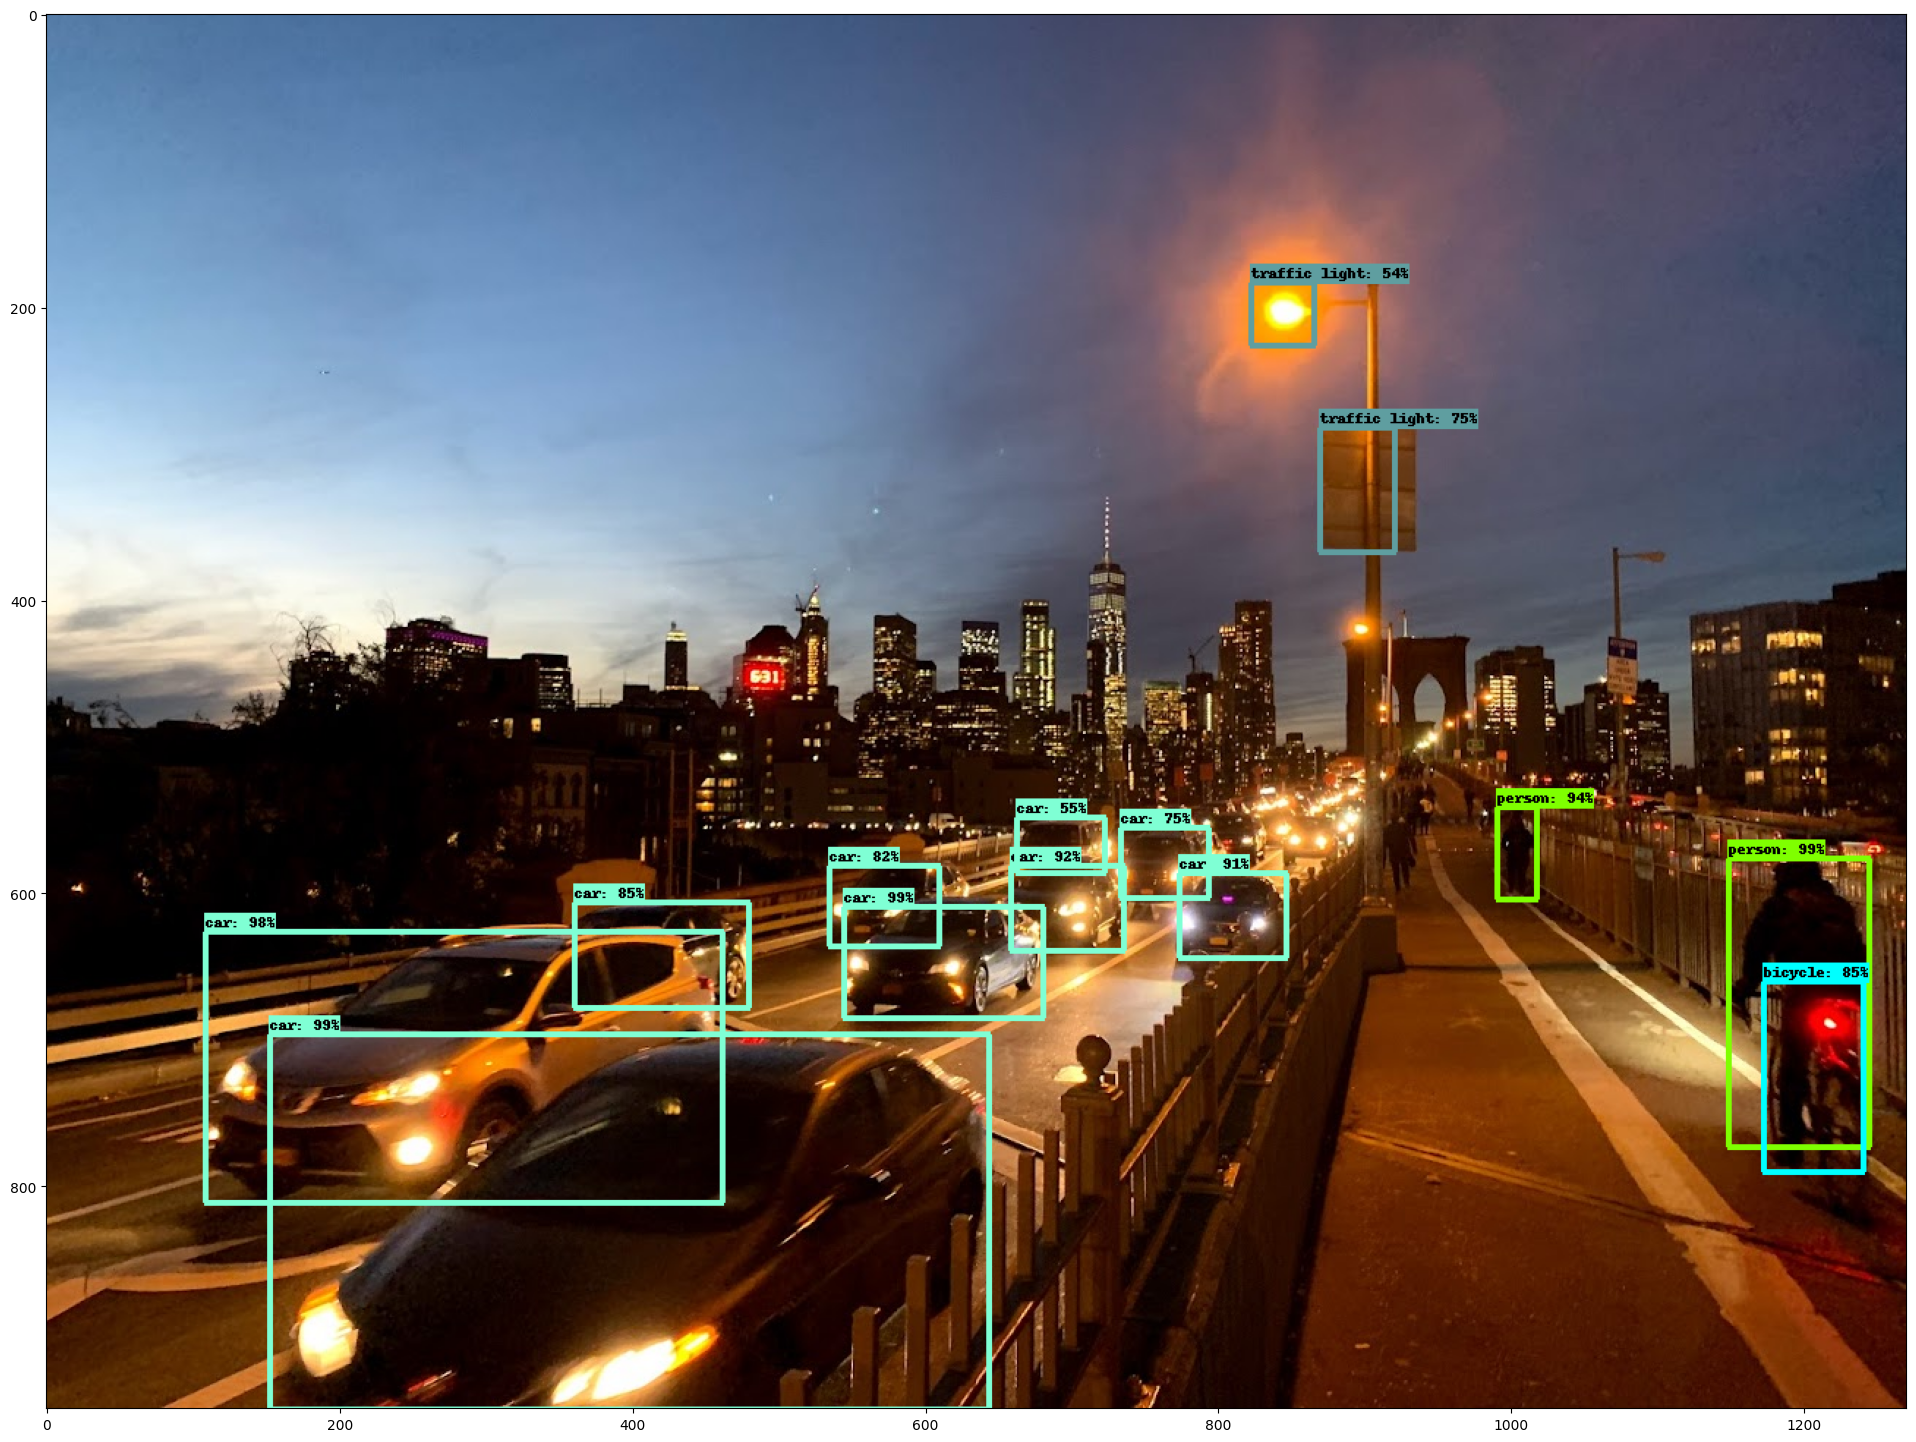

In [37]:
label_id_offset = 0
image_np_with_detections = image_np.copy()

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in model_outputs:
  keypoints = model_outputs['detection_keypoints'][0]
  keypoint_scores = model_outputs['detection_keypoint_scores'][0]
    
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      model_outputs['detection_boxes'][0].numpy(),
      (model_outputs['detection_classes'][0] + label_id_offset).numpy().astype(int),
      model_outputs['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.50,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      #keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS
)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_detections[0])
plt.show()

# Test case 2

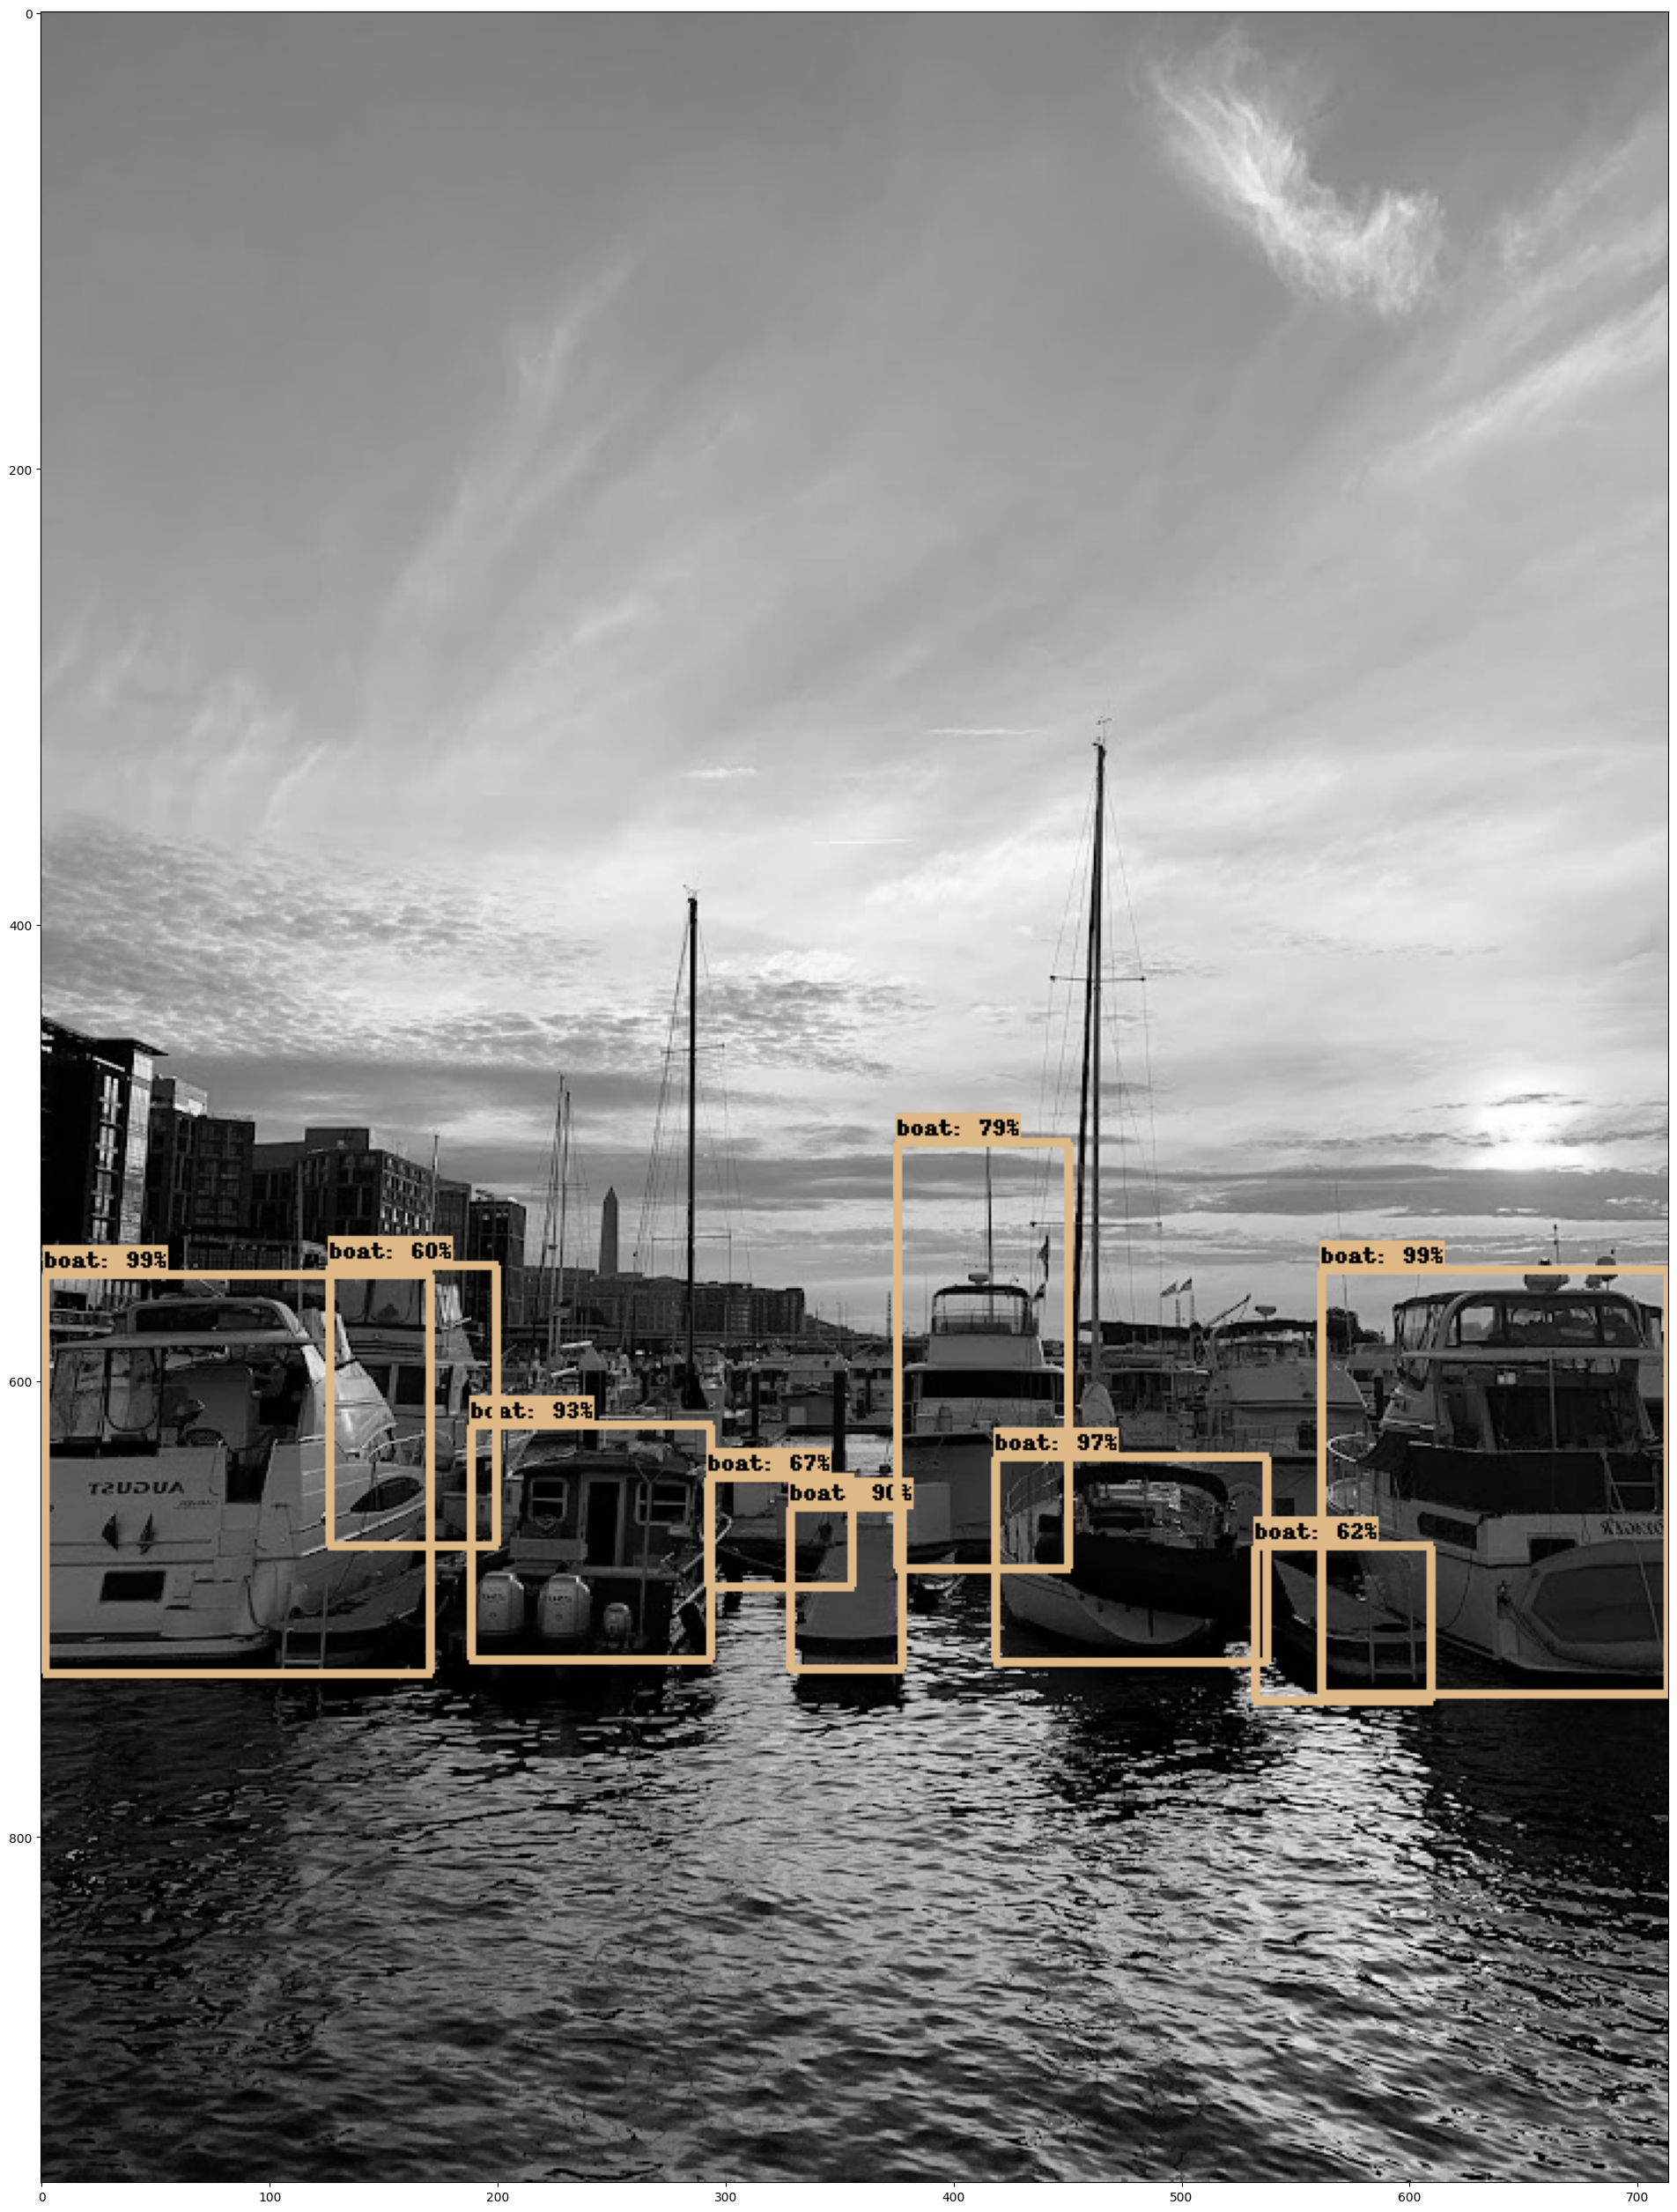

In [38]:
# import the image 
image_path = '/home/payam/bita/IMG_2946.jpg'
image_np = image_into_numpy_array(image_path)
# Flip the image horizontally
image_np[0] = np.fliplr(image_np[0]).copy()
# Convert the image to grayscale
image_np[0] = np.tile(np.mean(image_np[0], 2, keepdims=True), (1, 1, 3)).astype(np.uint8)


# model inference
model_outputs = model(image_np)

# plot with detections
label_id_offset = 0
image_np_with_detections = image_np.copy()

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in model_outputs:
  keypoints = model_outputs['detection_keypoints'][0]
  keypoint_scores = model_outputs['detection_keypoint_scores'][0]
    
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      model_outputs['detection_boxes'][0].numpy(),
      (model_outputs['detection_classes'][0] + label_id_offset).numpy().astype(int),
      model_outputs['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.50,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_detections[0])
plt.show()